In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 deer   cat truck   cat


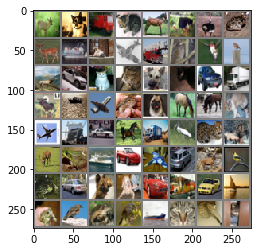

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 131, in get
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
    if timeout < 0 or not self._poll(timeout):
  File "/

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('%d loss: %.3f' %
          (epoch + 1, running_loss / 2000))

print('Finished Training')


1 loss: 0.900
2 loss: 0.881
3 loss: 0.791
4 loss: 0.717
5 loss: 0.640
6 loss: 0.594
7 loss: 0.568
8 loss: 0.547
9 loss: 0.529
10 loss: 0.514
Finished Training


In [6]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [11]:
class oSample(torch.autograd.Function):
    def forward(ctx, inputs):
        N = 16
        Q = pow(2, N-1) - 1
        delt = pow(2,-8)
        M = (inputs/delt).round()
        M[M>=Q] = Q
        M[M<-Q] = -(Q+1)
        S = delt*M
        return S
    def backward(ctx, g):
        return g

def sampleStateDict(net):
    Dict = net.state_dict()
    Key = Dict.keys()
    for i in Key:
        Dict[i] = oSample()(Dict[i])
    net.load_state_dict(Dict)

def protectStateDict(net):
    Dict = net.state_dict()
    Key = Dict.keys()
    for i in Key:
        Dict[i] = Dict[i]*1
    return Dict

In [12]:
class SampleNet(nn.Module):
    def __init__(self):
        super(SampleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = oSample()(self.pool(oSample()(F.relu(oSample()(self.conv1(x))))))
        x = oSample()(self.pool(oSample()(F.relu(oSample()(self.conv2(x))))))
        x = x.view(-1, 16 * 5 * 5)
        x = oSample()(F.relu(oSample()(self.fc1(x))))
        x = oSample()(F.relu(self.fc2(x)))
        x = oSample()(self.fc3(x))
        return x


sample_net = SampleNet()
sample_net.to(device)

SampleNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
def val():
    correct = 0
    total = 0
    TMP = protectStateDict(sample_net)
    sampleStateDict(sample_net)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = sample_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    sample_net.load_state_dict(TMP)
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    return 100.0 * correct / total

In [14]:
criterion_s = nn.CrossEntropyLoss()
#optimizer_s = optim.SGD(sample_net.parameters(), lr=0.0001, momentum=0.9)
optimizer_s = optim.Adam(sample_net.parameters(), lr=0.001)
def train(epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_s.zero_grad()

        # forward + backward + optimize
        TMP = protectStateDict(sample_net)
        sampleStateDict(sample_net)
        outputs = sample_net(inputs)
        loss = criterion_s(outputs, labels)
        loss.backward()
        sample_net.load_state_dict(TMP)
        optimizer_s.step()

        # print statistics
        running_loss += loss.item()
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / 1000))
    return running_loss

In [15]:
ttt = 0
rog = 10000
for epoch in range(100):  # loop over the dataset multiple times
    loss = train(epoch)
    if rog * 1000 < loss:
        break
    else:
        rog = loss
    acc = val()

[1,   782] loss: 1.317
Accuracy of the network on the 10000 test images: 45 %
[2,   782] loss: 1.100
Accuracy of the network on the 10000 test images: 51 %
[3,   782] loss: 0.994
Accuracy of the network on the 10000 test images: 55 %
[4,   782] loss: 0.916
Accuracy of the network on the 10000 test images: 57 %
[5,   782] loss: 0.867
Accuracy of the network on the 10000 test images: 59 %
[6,   782] loss: 0.819
Accuracy of the network on the 10000 test images: 60 %
[7,   782] loss: 0.782
Accuracy of the network on the 10000 test images: 61 %
[8,   782] loss: 0.752
Accuracy of the network on the 10000 test images: 62 %
[9,   782] loss: 0.723
Accuracy of the network on the 10000 test images: 63 %
[10,   782] loss: 0.696
Accuracy of the network on the 10000 test images: 64 %
[11,   782] loss: 0.674
Accuracy of the network on the 10000 test images: 64 %
[12,   782] loss: 0.654
Accuracy of the network on the 10000 test images: 64 %
[13,   782] loss: 0.633
Accuracy of the network on the 10000 

Process Process-130:
    self._target(*self._args, **self._kwargs)
Process Process-129:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    self._target(*self._args, **self._kwargs)
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 131, in get
    samples = collate_fn([dataset[i] for i in batch_indices])
    if timeout < 0 or not self._poll(timeout):
  Fil

KeyboardInterrupt: 